In [630]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import regularizers

In [631]:
wine_ds = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

In [632]:
df = pd.read_csv(wine_ds, delimiter=";")

In [633]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [634]:
# split the data such as 60% as training set, 20% for each set the validation set and test set
train, validate, test = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])
# make sure everything works 
len(df) == len(train) + len(validate) + len(test)

True

In [635]:
train_input, train_label = train.iloc[:,:-1], train.iloc[:,-1:]
validate_input, validate_label = validate.iloc[:,:-1], validate.iloc[:,-1:]
test_input, test_label = test.iloc[:,:-1], test.iloc[:,-1:]
# make sure everything works 
train_input.shape[1] == 11, train_label.shape[1] == 1

(True, True)

## Build Tensorflow Datasets [source](https://medium.com/when-i-work-data/converting-a-pandas-dataframe-into-a-tensorflow-dataset-752f3783c168)

In [636]:
train_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_input[train_input.columns].values, tf.float32),
            tf.cast(train_label.values, tf.uint8))))

validate_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(validate_input[validate_input.columns].values, tf.float32),
            tf.cast(validate_label.values, tf.uint8))))

test_tfds = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_input[test_input.columns].values, tf.float32),
            tf.cast(test_label.values, tf.uint8))))


### find the median of the labels to create a "decent" threshold

In [684]:
train_median = []
for features_tensor, target_tensor in train_tfds:
    train_median.append(target_tensor)

validate_median = []
for features_tensor, target_tensor in validate_tfds:
    validate_median.append(target_tensor)

test_median = []
for features_tensor, target_tensor in test_tfds:
    test_median.append(target_tensor)

np.median(test_median) == np.median(validate_median) == np.median(train_median)



True

In [687]:
train_median = []
for features_tensor, target_tensor in train_tfds_norm:
    train_median.append(target_tensor)

validate_median = []
for features_tensor, target_tensor in validate_tfds_norm:
    validate_median.append(target_tensor)

test_median = []
for features_tensor, target_tensor in test_tfds_norm:
    test_median.append(target_tensor)

print(np.mean(train_median))
np.median(test_median) == np.median(validate_median) == np.median(train_median)

0.013555787278415016


True

In [ ]:
print(train_median)

In [638]:
thershold = np.median(test_median) 
def make_binary(target):
    if target >= thershold: 
        return tf.constant(1, dtype=tf.float32)
    return tf.constant(0, dtype=tf.float32)

def make_binary_normalised(target):
    if float(target) >= 0.6: 
        return tf.constant(1, dtype=tf.float32)
    return tf.constant(0, dtype=tf.float32)

## Create Normalised Input

In [639]:
# normalize every input except the label
x = df.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_normalised = pd.DataFrame(x_scaled)
df_normalised.columns = df.columns

train_norm, validate_norm, test_norm = np.split(df_normalised.sample(frac=1, random_state=42), [int(.6*len(df_normalised)), int(.8*len(df_normalised))])

train_input_norm, train_label_norm = train_norm.iloc[:,:-1], train_norm.iloc[:,-1:]
validate_input_norm, validate_label_norm = validate_norm.iloc[:,:-1], validate_norm.iloc[:,-1:]
test_input_norm, test_label_norm = test_norm.iloc[:,:-1], test_norm.iloc[:,-1:]


train_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(train_input_norm[train_input_norm.columns].values, tf.float32),
            tf.cast(train_label_norm.values, tf.uint8))))

validate_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(validate_input_norm[validate_input_norm.columns].values, tf.float32),
            tf.cast(validate_label_norm.values, tf.uint8))))

test_tfds_norm = (tf.data.Dataset.from_tensor_slices((
            tf.cast(test_input_norm[test_input_norm.columns].values, tf.float32),
            tf.cast(test_label_norm.values, tf.uint8))))

In [640]:
train_median_norm = []
for features_tensor, target_tensor in train_tfds_norm:
    train_median_norm.append(target_tensor[0])

validate_median = []
for features_tensor, target_tensor in validate_tfds_norm:
    validate_median.append(target_tensor[0])

test_median = []
for features_tensor, target_tensor in test_tfds_norm:
    test_median.append(target_tensor[0])

print(np.median(train_median_norm))
np.median(test_median) == np.median(validate_median) == np.median(train_median_norm)

0.0


True

In [641]:
# credits to group 8 ^.^
batch_size = 32
shuffle = 1000
def preprocessing(ds):
    global batch_size, shuffle
    ds = ds.map(lambda feature, label: (feature, make_binary(label)))

    ds = ds.cache()
    ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(100)
    return ds

def preprocessing_normalised(ds):
    global batch_size, shuffle
    ds = ds.map(lambda feature, label: (feature, make_binary_normalised(label)))

    ds = ds.cache()
    ds = ds.shuffle(shuffle)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(100)
    return ds


In [642]:
def change_batch_size(batch_sz, shuff):
    """needed when the batch size is changed"""
    global batch_size, shuffle
    batch_size = batch_sz
    shuffle = shuff
    
    train_ds = train_tfds.apply(preprocessing)
    validate_ds = validate_tfds.apply(preprocessing)
    test_ds = test_tfds.apply(preprocessing)


In [643]:
train_ds = train_tfds.apply(preprocessing)
validate_ds = validate_tfds.apply(preprocessing)
test_ds = test_tfds.apply(preprocessing)

In [644]:
train_ds_norm = train_tfds_norm.apply(preprocessing_normalised)
validate_ds_norm = validate_tfds_norm.apply(preprocessing_normalised)
test_ds_norm = test_tfds_norm.apply(preprocessing_normalised)

## Model and Layer of last week's assigment of group 8

In [645]:
# credits to group 8!
class DenseLayer(tf.keras.layers.Layer):
    def __init__(self, units, activation, kernel_regularizer = None):

        super(DenseLayer, self).__init__(kernel_regularizer)
        self.units = units
        self.activation = activation

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer='random_normal', trainable=True)
        self.b= self.add_weight(shape=(self.units,), initializer='random_normal', trainable=True)

    def call(self, inputs):
        """Compute forward pass through layer."""
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [646]:
class MyModel(tf.keras.Model):
    def __init__(self, loss_function, optimizer, kernel_regularizer= None):
        super(MyModel, self).__init__()

        self.hidden_layer1 = DenseLayer(128, tf.nn.sigmoid, kernel_regularizer= kernel_regularizer)
        # self.hidden_layer2 = DenseLayer(50, tf.nn.sigmoid, kernel_regularizer= kernel_regularizer)
        self.output_layer = DenseLayer(1, tf.nn.sigmoid)

        self.loss_function = loss_function
        self.optimizer = optimizer

    
    def call(self, inputs):
        output_hidden_layer1 = self.hidden_layer1(inputs)
        # output_hidden_layer2 = self.hidden_layer2(output_hidden_layer1)
        output_network = self.output_layer(output_hidden_layer1)

        return output_network
        
    def train(self, input, target):
        with tf.GradientTape() as tape:
            prediction = self(input)
            loss = self.loss_function(prediction, target)
        gradients = tape.gradient(loss, self.trainable_variables)
        if self.optimizer:
            self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        same_prediction = np.round(target,0) == np.round(prediction, 0)
        accuracy = np.mean(same_prediction)
        return loss, accuracy

    def test(self, test_data):
        """Calculate the mean loss and accuracy of the model over all elements
        of test_data.

        :param test_data: model is evaulated for test_data
        :type test_data: tensorflow 'Dataset'
        :return: mean loss and mean accuracy for all datapoints
        :rtype: tuple of two floats
        """
        # aggregator lists for tracking the loss and accuracy
        test_accuracy_agg = []
        test_loss_agg = []
        # iterate over all input-target pairs in test_data
        for (input, target) in test_data:
            prediction = self(input)
            loss = self.loss_function(target, prediction)
            same_prediction = np.round(target,0) == np.round(prediction, 0)
            accuracy = np.mean(same_prediction)
            # add loss and accuracy to aggregators
            test_loss_agg.append(loss.numpy())
            test_accuracy_agg.append(np.mean(accuracy))
        # calculate mean loss and accuracy
        test_loss = tf.reduce_mean(test_loss_agg)
        test_accuracy = tf.reduce_mean(test_accuracy_agg)
        return test_loss, test_accuracy

## Training

In [647]:
# Initialize lists for tracking loss and accuracy
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
validate_losses = []
validate_accuracies = []
def initialise():
    global train_losses
    train_losses = []
    global train_accuracies
    train_accuracies = []
    global test_losses 
    test_losses = []
    global test_accuracies
    test_accuracies = []
    global validate_losses 
    validate_losses = []
    global validate_accuracies
    validate_accuracies = []

In [648]:
def train(optimizer, kernel_regularizer = None, momentum = None, norm = False, early_stopping=False):    
    tf.keras.backend.clear_session()

    # Setting Hyperparameters
    EPOCHS = 10
    LEARNING_RATE = 0.1

    # Initialize the loss-function
    binary_cross__loss = tf.keras.losses.BinaryCrossentropy()
    # Initialize the optimizer
    if momentum:
        optimizer = optimizer(LEARNING_RATE, momentum = momentum)
    else:
        if optimizer:
            optimizer = optimizer(LEARNING_RATE)
    # Initialize the model
    model = MyModel(binary_cross__loss, optimizer, kernel_regularizer)

    if norm:
        validate_data = validate_ds_norm
        test_data = test_ds_norm
        train_data = train_ds_norm
    else:
        validate_data = validate_ds
        test_data = test_ds
        train_data = train_ds

    # Testing models performance before training starts.
    # Test-Dataset
    test_loss, test_accuracy = model.test(test_data)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    # Train-Dataset
    train_loss, train_accuracy = model.test(train_data)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Validate-Dataset
    validate_loss, validate_accuracy = model.test(validate_data)
    validate_losses.append(validate_loss)
    validate_loss_previous = validate_loss
    validate_accuracies.append(validate_accuracy)

    

    # Training for EPOCHS.
    for epoch in range(EPOCHS+1):
        print(f'\033[0;37;40m Epoch {str(epoch)} starting with test-accuracy of {np.round(test_accuracies[-1],3)}')
        print(f'\033[0;32;40m Epoch {str(epoch)} starting with validate-accuracy of {np.round(validate_accuracies[-1],3)}')
        epoch_loss_agg = []
        epoch_accuracy_agg = []
        for input, target in train_data:
            train_loss, train_accuracy = model.train(input, target)
            epoch_loss_agg.append(train_loss)
            epoch_accuracy_agg.append(train_accuracy)
            
        # track training loss and accuracy
        train_losses.append(tf.reduce_mean(epoch_loss_agg))
        train_accuracies.append(tf.reduce_mean(epoch_accuracy_agg))
        # track loss and accuracy for test-dataset
        test_loss, test_accuracy = model.test(test_data)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        # track loss and accuracy for validare-dataset
        validate_loss, validate_accuracy = model.test(validate_data)
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)

        # early stopping
        if early_stopping:
            if ((float(validate_loss_previous) < float(validate_loss))):
                break

        validate_loss_previous = validate_loss


In [649]:
def visualize():
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(20, 6)

    fig.suptitle('Training Progress for Wine Quality Classification')
    axs[0].plot(train_losses, color='orange', label='train losses')
    axs[0].plot(test_losses, color='green', label='test losses')
    axs[0].plot(validate_losses, color='blue', label='validate losses')

    axs[0].set(ylabel='Losses')
    axs[0].legend()
    axs[1].plot(train_accuracies, color='orange', label='train accuracies')
    axs[1].plot(test_accuracies, color='green', label='test accuracies')
    axs[1].plot(validate_accuracies, color='blue', label='validate losses')

    axs[1].set(xlabel='Epochs', ylabel='Accuracies')
    axs[1].legend()

## Training on Batch Size of 1024

In [650]:
change_batch_size(1024, 20000)


In [674]:
for features_tensor, target_tensor in train_ds.take(3):
    print(f'features:{features_tensor} target:{target_tensor}')

features:[[7.8000e+00 4.3000e-01 7.0000e-01 1.9000e+00 4.6400e-01 2.2000e+01
  6.7000e+01 9.9740e-01 3.1300e+00 1.2800e+00 9.4000e+00]
 [7.2000e+00 6.3000e-01 0.0000e+00 1.9000e+00 9.7000e-02 1.4000e+01
  3.8000e+01 9.9675e-01 3.3700e+00 5.8000e-01 9.0000e+00]
 [9.0000e+00 4.0000e-01 4.3000e-01 2.4000e+00 6.8000e-02 2.9000e+01
  4.6000e+01 9.9430e-01 3.2000e+00 6.0000e-01 1.2200e+01]
 [6.4000e+00 4.0000e-01 2.3000e-01 1.6000e+00 6.6000e-02 5.0000e+00
  1.2000e+01 9.9580e-01 3.3400e+00 5.6000e-01 9.2000e+00]
 [8.5000e+00 4.9000e-01 1.1000e-01 2.3000e+00 8.4000e-02 9.0000e+00
  6.7000e+01 9.9680e-01 3.1700e+00 5.3000e-01 9.4000e+00]
 [7.0000e+00 6.2000e-01 1.8000e-01 1.5000e+00 6.2000e-02 7.0000e+00
  5.0000e+01 9.9510e-01 3.0800e+00 6.0000e-01 9.3000e+00]
 [7.2000e+00 6.6000e-01 3.0000e-02 2.3000e+00 7.8000e-02 1.6000e+01
  8.6000e+01 9.9743e-01 3.5300e+00 5.7000e-01 9.7000e+00]
 [5.2000e+00 3.4000e-01 0.0000e+00 1.8000e+00 5.0000e-02 2.7000e+01
  6.3000e+01 9.9160e-01 3.6800e+00 7.9000

In [652]:
initialise()
train(None)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

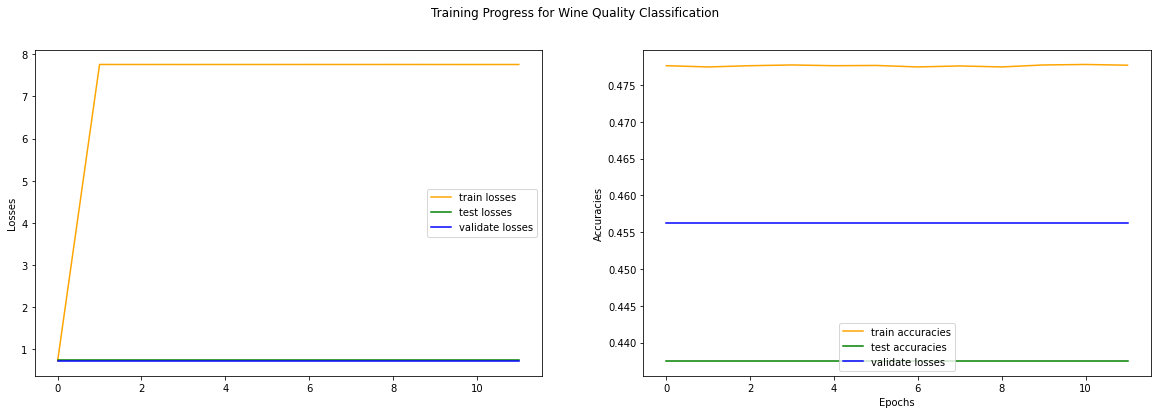

In [653]:
visualize()

## Training on Batch Size of 64

In [654]:
change_batch_size(64, 1000)

In [655]:
initialise()
train(None)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

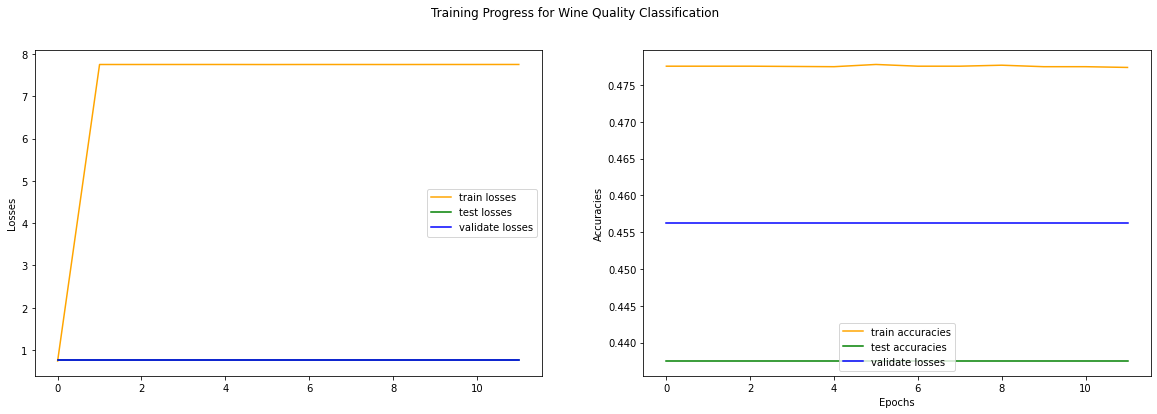

In [656]:
visualize()

We can see improvement of almost 3% in the larger batch size, which is predictable since we have more gradient updates due to a larger size

## SGD with no Momentum + (batch size of 64 from here till the end of the notebook)

In [657]:
initialise()
train(tf.keras.optimizers.SGD)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

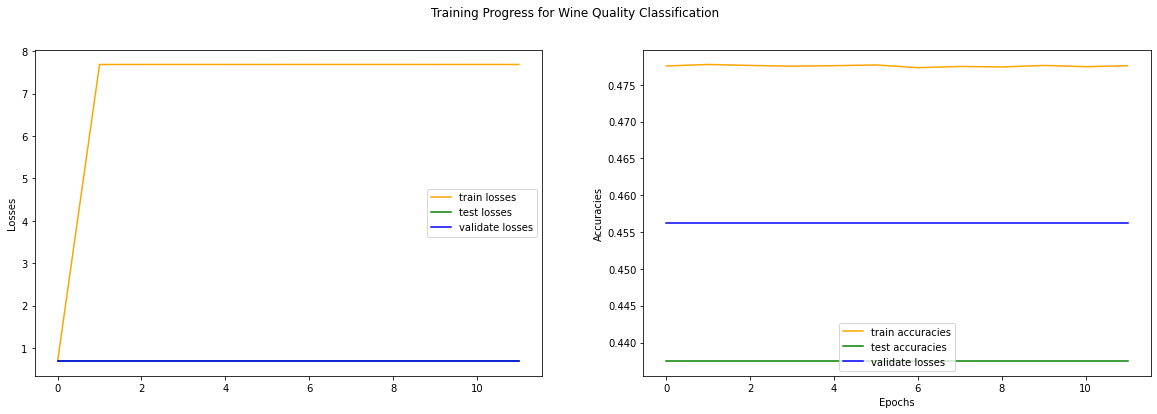

In [658]:
visualize()

SGD helps improving the performane to a certain extent due to the randomness.

## Using SGD with Momentum

In [659]:
initialise()
train(tf.keras.optimizers.SGD, momentum=0.6)

 Epoch 0 starting with test-accuracy of 0.437
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.437
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.437
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.437
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

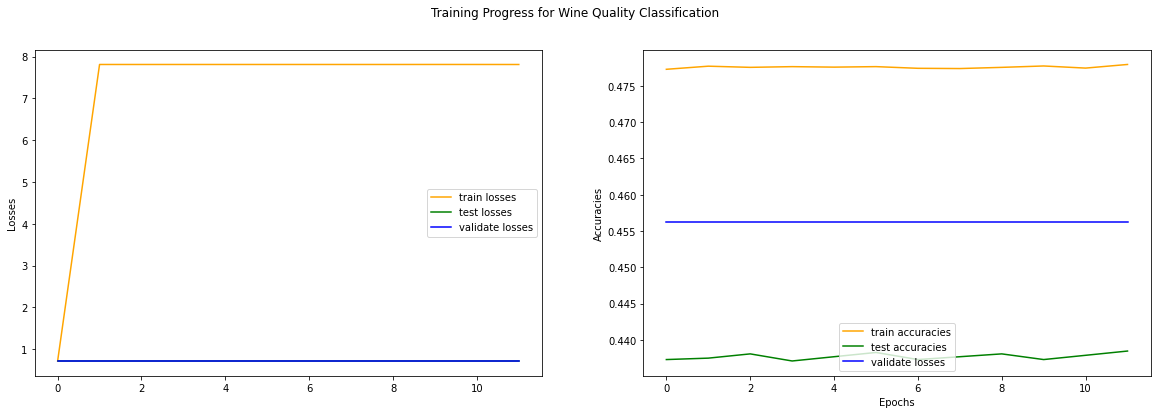

In [660]:
visualize()

## Using AdamOptimiser

In [661]:
initialise()
train(tf.keras.optimizers.Adam)

 Epoch 0 starting with test-accuracy of 0.547
 Epoch 0 starting with validate-accuracy of 0.535
 Epoch 1 starting with test-accuracy of 0.541
 Epoch 1 starting with validate-accuracy of 0.541
 Epoch 2 starting with test-accuracy of 0.548
 Epoch 2 starting with validate-accuracy of 0.535
 Epoch 3 starting with test-accuracy of 0.548
 Epoch 3 starting with validate-accuracy of 0.531
 Epoch 4 starting with test-accuracy of 0.547
 Epoch 4 starting with validate-accuracy of 0.53
 Epoch 5 starting with test-accuracy of 0.549
 Epoch 5 starting with validate-accuracy of 0.53
 Epoch 6 starting with test-accuracy of 0.547
 Epoch 6 starting with validate-accuracy of 0.53
 Epoch 7 starting with test-accuracy of 0.544
 Epoch 7 starting with validate-accuracy of 0.532
 Epoch 8 starting with test-accuracy of 0.542
 Epoch 8 starting with validate-accuracy of 0.528
 Epoch 9 starting with test-accuracy of 0.55
 Epoch 9 starting with validate-accuracy of 0.531
 Epoch 10 starting with test-accuracy of 0.5

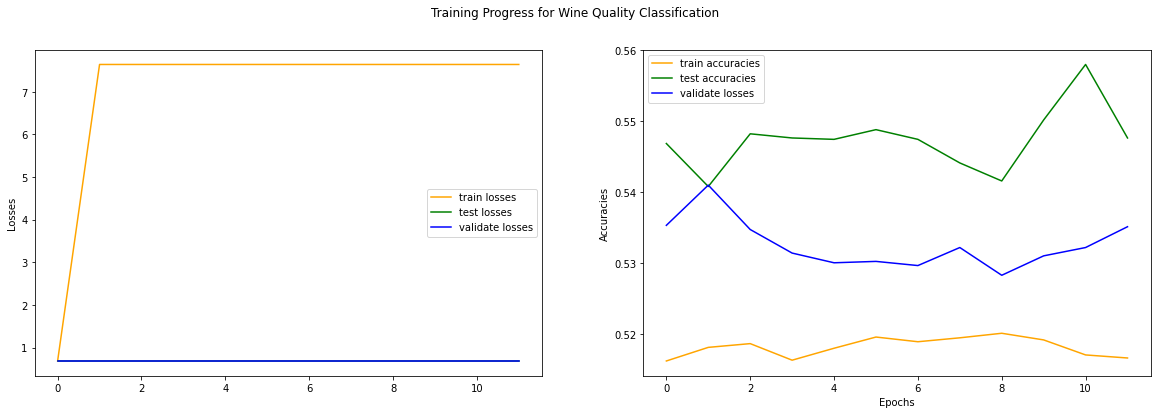

In [662]:
visualize()

## Using AdamOptimiser + Early Stopping

In [663]:
initialise()
train(tf.keras.optimizers.Adam, early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456
 Epoch 1 starting with test-accuracy of 0.438
 Epoch 1 starting with validate-accuracy of 0.456
 Epoch 2 starting with test-accuracy of 0.438
 Epoch 2 starting with validate-accuracy of 0.456
 Epoch 3 starting with test-accuracy of 0.438
 Epoch 3 starting with validate-accuracy of 0.456
 Epoch 4 starting with test-accuracy of 0.438
 Epoch 4 starting with validate-accuracy of 0.456
 Epoch 5 starting with test-accuracy of 0.438
 Epoch 5 starting with validate-accuracy of 0.456
 Epoch 6 starting with test-accuracy of 0.438
 Epoch 6 starting with validate-accuracy of 0.456
 Epoch 7 starting with test-accuracy of 0.438
 Epoch 7 starting with validate-accuracy of 0.456
 Epoch 8 starting with test-accuracy of 0.438
 Epoch 8 starting with validate-accuracy of 0.456
 Epoch 9 starting with test-accuracy of 0.438
 Epoch 9 starting with validate-accuracy of 0.456
 Epoch 10 starting with test-accuracy of

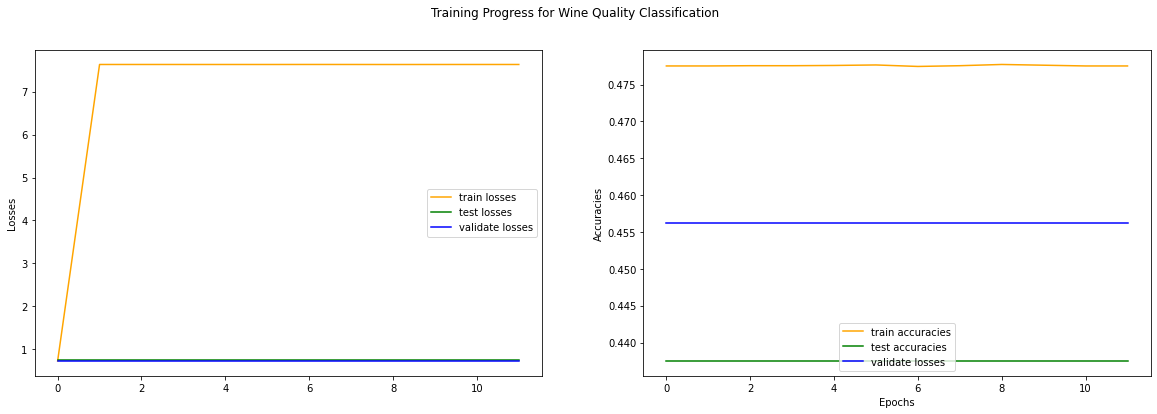

In [664]:
visualize()

## Using regularizer L1 and Adam

In [665]:
initialise()
train(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l1(l1=0.01),early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456


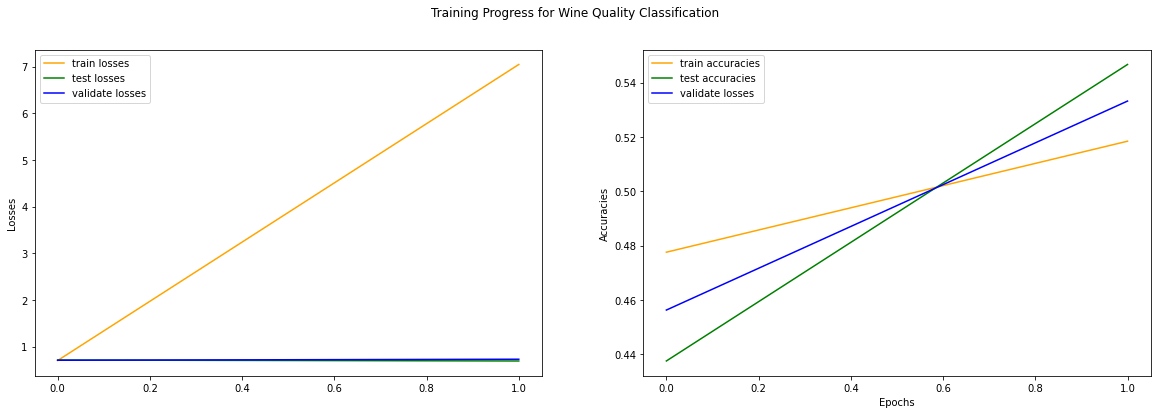

In [666]:
visualize()

## Using regularizer L12 and Adam

In [667]:
initialise()
train(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l2(l2=0.01),early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.438
 Epoch 0 starting with validate-accuracy of 0.456


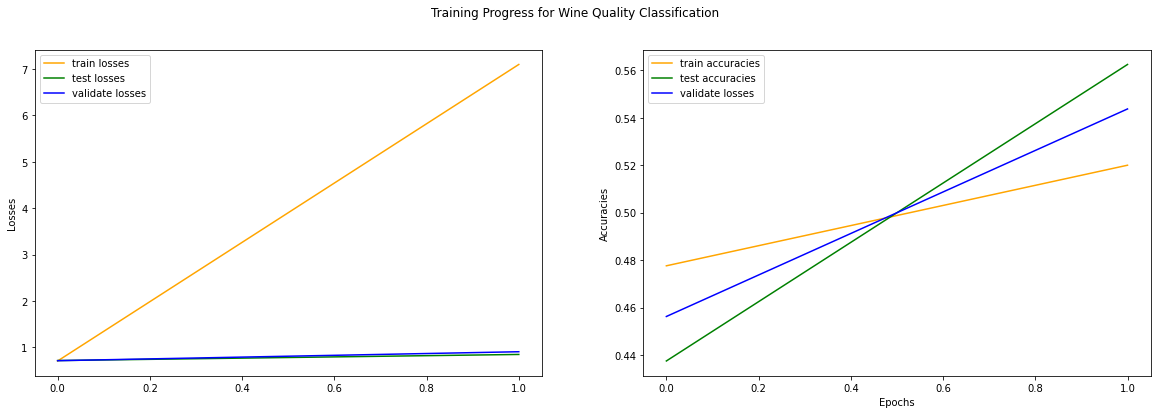

In [668]:
visualize()

## Using regularizer L1 and L2 + Adam

In [669]:
initialise()
train(tf.keras.optimizers.Adam, kernel_regularizer= regularizers.l1_l2(l1=0.01, l2=0.01), early_stopping=True)

 Epoch 0 starting with test-accuracy of 0.562
 Epoch 0 starting with validate-accuracy of 0.544


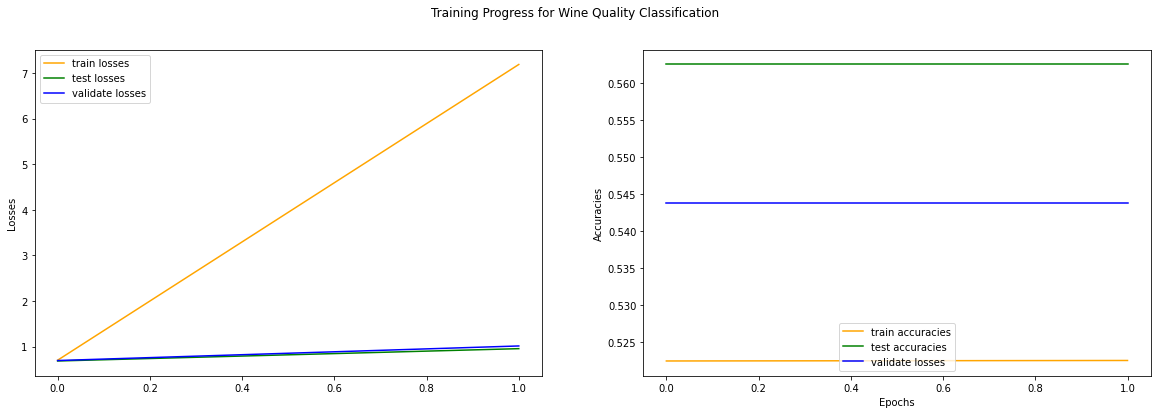

In [670]:
visualize()

After all the different optimisation and regulisation techniques we tried we got an acuurcay of 56.2% on the test data

## Try the normalized Data

In [671]:
change_batch_size(64,1000)

In [1]:
initialise()
train(None, norm=True)

NameError: name 'initialise' is not defined

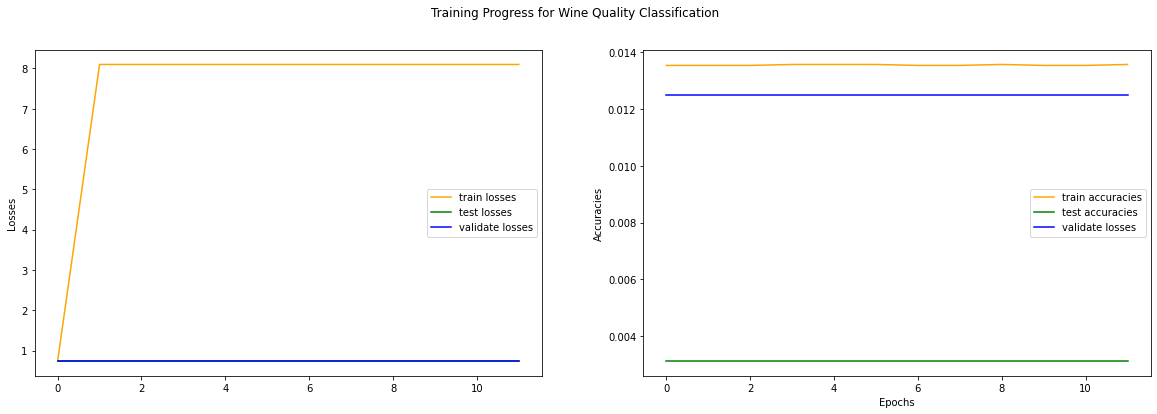

In [673]:
visualize()